<a href="https://colab.research.google.com/github/imitusov/ieee-fraud-detection/blob/master/ieee_fraud_detection_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment preparation

In [0]:
%load_ext autoreload
%autoreload 2
%xmode Plain
%pdb off

Exception reporting mode: Plain
Automatic pdb calling has been turned OFF


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  

kaggle.json


In [0]:
!pip install -U imbalanced-learn
!pip install Boruta
!pip install category_encoders
!pip install pydrive
!pip install catboost
!pip install bayesian-optimization

In [0]:
# Change root to target foldet
import os
root_path = '/content/gdrive/My Drive/Colab Notebooks/IEEE (Kaggle)/'
os.chdir(root_path)

In [0]:
!kaggle competitions download -c ieee-fraud-detection -p '/content/gdrive/My Drive/Colab Notebooks/IEEE (Kaggle)/'

In [0]:
!unzip train_identity.csv.zip
!unzip train_transaction.csv.zip
!unzip test_identity.csv.zip
!unzip test_transaction.csv.zip
!unzip sample_submission.csv.zip

# Import Data

In [0]:
import imports
import dama as dm
import numpy as np
import scipy.stats as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import imblearn
import boruta
from sklearn import preprocessing, ensemble
import gc
import lightgbm as lgb
np.random.seed(17)
%matplotlib inline

Using TensorFlow backend.


In [0]:
# Allow permission to read and write file
# https://stackoverflow.com/questions/50552404/oserror-initializing-from-file-failed-on-csv-in-pandas

!chmod 644 '{root_path}train_identity.csv'
!chmod 644 '{root_path}train_transaction.csv'

In [0]:
%%time
df_train_id = pd.read_csv(f'{root_path}train_identity.csv')
df_train_tr = pd.read_csv(f'{root_path}train_transaction.csv')

CPU times: user 33.6 s, sys: 4.47 s, total: 38.1 s
Wall time: 40.5 s


In [0]:
y_train = df_train_tr.loc[:, 'isFraud']
y_train.to_csv(f'{root_path}y_train.csv', index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


## Reduce memory usage

In [0]:
%%time
dm.reduce_mem_usage(df_train_id)
dm.reduce_mem_usage(df_train_tr)
resume_table = dm.resume_table(df_train_tr)

# Graphs

## Target variable

In [0]:
# Data for graph
df_train_tr['TransactionAmt'] = df_train_tr['TransactionAmt'].astype('float64') 
is_fraud = df_train_tr[df_train_tr['isFraud'] == 1]['TransactionAmt'].count()
no_fraud = df_train_tr[df_train_tr['isFraud'] == 0]['TransactionAmt'].count()
is_fraud_perc = round(is_fraud / df_train_tr['TransactionAmt'].count() * 100, 2)
no_fraud_perc = round(no_fraud / df_train_tr['TransactionAmt'].count() * 100, 2)
is_fraud_t = df_train_tr[df_train_tr['isFraud'] == 1]['TransactionAmt'].sum()
no_fraud_t = df_train_tr[df_train_tr['isFraud'] == 0]['TransactionAmt'].sum()
is_fraud_t_perc = round(is_fraud_t / df_train_tr['TransactionAmt'].sum() * 100, 2)
no_fraud_t_perc = round(no_fraud_t / df_train_tr['TransactionAmt'].sum() * 100, 2)
fraud_count = [is_fraud, no_fraud]
fraud_count_perc = [is_fraud_perc, no_fraud_perc]
fraud_sum = [is_fraud_t, no_fraud_t]
fraud_sum_perc = [is_fraud_t_perc, no_fraud_t_perc]

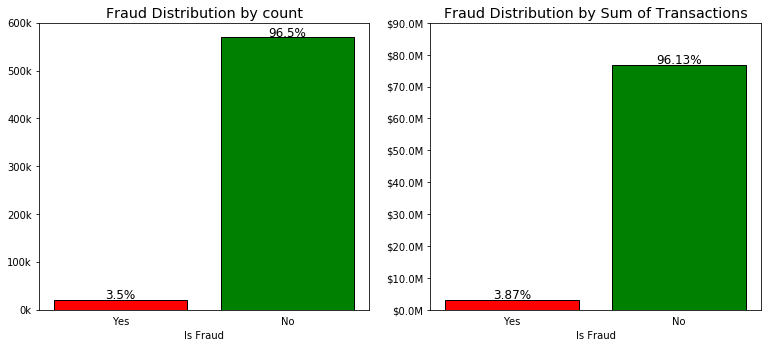

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
plt.style.use('classic')
fig.patch.set_facecolor('xkcd:white')

def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.0fk' % (x * 1e-3)

def millions(x, pos):
    'The two args are the value and tick position'
    return '$%1.1fM' % (x * 1e-6)


ax[0].bar(['Yes', 'No'], fraud_count, color=['r', 'g'])
ax[0].set_xlabel('Is Fraud')
ax[0].set_title('Fraud Distribution by count')
ax[0].tick_params(axis='x', which='both', bottom=False, top=False)
ax[0].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(thousands))
for number_x, number_y in enumerate(fraud_count):
    ax[0].text(number_x, number_y + 2000, 
               str(fraud_count_perc[number_x]) + '%', ha='center')

ax[1].bar(['Yes', 'No'], fraud_sum, color=['r', 'g'])
ax[1].set_xlabel('Is Fraud')
ax[1].set_title('Fraud Distribution by Sum of Transactions')
ax[1].tick_params(axis='x', which='both', bottom=False, top=False)
ax[1].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(millions))
for number_x, number_y in enumerate(fraud_sum):
    ax[1].text(number_x, number_y + 500000, 
               str(fraud_sum_perc[number_x]) + '%', ha='center')

plt.tight_layout()
plt.show()

# There are 3.5% of fraud transactions in a Dataset - class proportion is really unbalanced (Thank god!)
# Transaction amount that is frauded a bit higher - 3.87%

## Transactions amount

### Quantilies

In [0]:
trans_quant = df_train_tr['TransactionAmt'].quantile(
    [.01, .025, .1, .25, 0.5, 0.75, 0.9, 0.975, 0.99]).reset_index()
trans_quant_f = df_train_tr[df_train_tr['isFraud'] == 1]['TransactionAmt'].quantile(
    [.01, .025, .1, .25, 0.5, 0.75, 0.9, 0.975, 0.99]).reset_index()
trans_quant_nf = df_train_tr[df_train_tr['isFraud'] == 0]['TransactionAmt'].quantile(
    [.01, .025, .1, .25, 0.5, 0.75, 0.9, 0.975, 0.99]).reset_index()

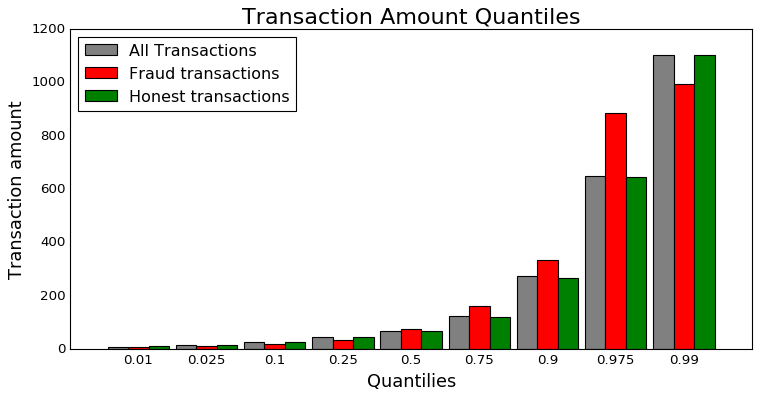

In [0]:
fig, ax = plt.subplots(1, 1, figsize=(11, 5))
plt.style.use('classic')
fig.patch.set_facecolor('xkcd:white')
ind = np.arange(1, len(trans_quant) + 1)
width = 0.3

ax.bar(ind - width, trans_quant['TransactionAmt'], width, color='grey',
       label='All Transactions')
ax.bar(ind, trans_quant_f['TransactionAmt'], width, color='r',
       label='Fraud transactions')
ax.bar(ind + width, trans_quant_nf['TransactionAmt'], width, color='g',
       label='Honest transactions')
ax.set_xticks(ind)
ax.set_xticklabels(trans_quant['index'].astype(str).to_list())
ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
ax.legend(loc='best')
ax.set_xlabel('Quantilies', fontsize=16)
ax.set_ylabel('Transaction amount', fontsize=16)
ax.set_title('Transaction Amount Quantiles', fontsize=20)
plt.show()

# Transaction amount with fraud tends to have higher values in from quantiles > 0.5 till 0.95 quantile
# Average transaction amount may have significant indluence on fraud detecetion
# Probably we should delete outliers from TransactionAmt to improve clf performance 

### Log distribution

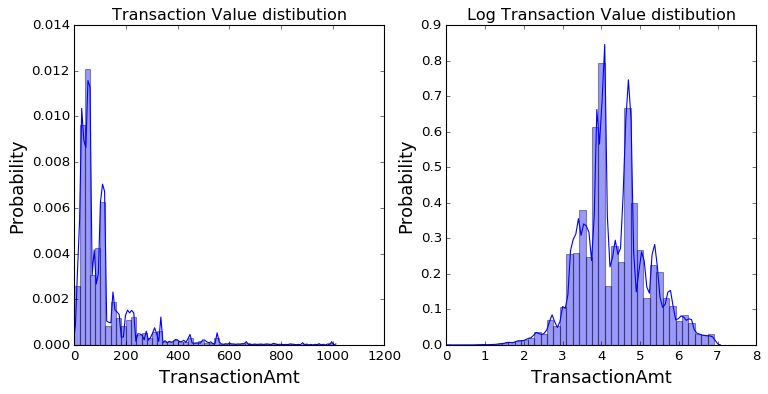

In [0]:
fig, axs = plt.subplots(1, 2, figsize=(11, 5))
plt.style.use('classic')
fig.patch.set_facecolor('xkcd:white')

ax = axs[0]
ax = sns.distplot(df_train_tr[df_train_tr['TransactionAmt'] <= 1000]['TransactionAmt'], ax=ax)
ax.set_xlabel('TransactionAmt', fontsize=16)
ax.set_title('Transaction Value distibution')
ax.set_ylabel('Probability', fontsize=16)
ax.axis(xmin=0)

ax = axs[1]
ax = sns.distplot(np.log(df_train_tr[df_train_tr['TransactionAmt'] <= 1000]['TransactionAmt']), ax=ax)
ax.set_xlabel('TransactionAmt', fontsize=16)
ax.set_title('Log Transaction Value distibution')
ax.set_ylabel('Probability', fontsize=16)
ax.axis(xmin=0)

plt.show()

# Transactional value distributiol is very right-skewed - we would possible need to apply transformation
# Log transformation of value is closer to normal but still has two peaks

## Category type variable

In [0]:
def cat_graph(df: pd.DataFrame, cat_col: str, target_col: str, agr_col: str,
              miss=False, miss_val=False):
    '''
    Plots category distribution and category distribution by binary target

    param df:
        Dataframe
    param cat_col:
        Category column name in string format
    param target_col:
        Binary variable to split
    param agr_col:
        Column to aggregate by (i.e. ID)
    param miss:
        Boolean, whether to treat NaN
    param miss_val:
        value to replace NaN
    '''

    # Prepare set for first chart  
    df_ = df.copy()
    if miss:
        df_[cat_col] = df_[cat_col].fillna(miss_val)
    product_cat = df_.groupby(cat_col)[agr_col].count().reset_index()
    product_cat.rename({agr_col: 'count'}, inplace=True, axis=1)
    target_column = df_[df_[target_col] == 1]\
                                .groupby(cat_col)[agr_col].count()\
                                .to_frame(name=target_col)
    product_cat = product_cat.join(target_column, sort=False, how='left',
                                   on=cat_col).fillna(0) 
    n_target_col = 'not_' + target_col 
    s_target_col = 'share_' + target_col
    s_n_target_col = 'share_not_' + target_col
    s_cat_col = 'share' + cat_col
    n_target_column = df_[df_[target_col] == 0]\
                                .groupby(cat_col)[agr_col].count()\
                                .to_frame(name=n_target_col)
    product_cat = product_cat.join(n_target_column, sort=False, how='left',
                                   on=cat_col).fillna(0) 
    product_cat[s_target_col] = product_cat[target_col] / product_cat['count']
    product_cat[s_n_target_col] = product_cat[n_target_col] / product_cat['count']
    product_cat[s_cat_col] = round(product_cat['count'] / product_cat['count']\
                                            .sum() * 100, 1)
    product_cat = product_cat.sort_values('count', axis=0, ascending=False)\
                                            .reset_index(drop=True)
    product_cat = product_cat.drop([s_n_target_col], axis=1)
    
    # Data for second chart
    product_cat_1 = product_cat.melt(id_vars=[cat_col, s_target_col],
                                value_vars=[target_col, n_target_col])\
                                .sort_values('value', ascending=False)\
                                .reset_index(drop=True)

    # Code for graphs
    fig, axs = plt.subplots(1, 2, figsize=(11, 5))
    plt.style.use('classic')
    fig.patch.set_facecolor('xkcd:white')
    fig.suptitle(f'{cat_col} Distribution', fontsize='x-large', y=1.05)

    def thousands(x, pos):
        'The two args are the value and tick position'
        x = (x * 1e-3)
        return f'{x:.0f}k' 

    def percentes(x, pos):
        'The two args are the value and tick position'
        x = (x * 1e2)
        return f'{x:.0f}%' 

    ax = axs[0]
    ax = sns.barplot(x=cat_col, y='count', data=product_cat, ax=ax)
    sns.despine(top=True, right=True, left=False, bottom=False, ax=ax)
    ax.set_xlabel('Product Category', fontsize=16)
    ax.set_ylabel('Count', fontsize=16)
    ax.set_title('Product Category Distribution', fontsize=18)
    ax.tick_params(axis='x', which='both', bottom=False, top=False)
    ax.tick_params(axis='y', which='both', right=False, direction='out')
    for x_number, y_number in enumerate(product_cat['count']):
        ax.text(x_number, y_number + 2000, str(product_cat[s_cat_col][x_number])\
                + '%', ha='center')
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(thousands))    


    ax = axs[1]
    ax1 = ax.twinx()
    sns.barplot(x=cat_col, y='value', hue='variable', data=product_cat_1, ax=ax)
    sns.pointplot(x=cat_col, y=s_target_col, data=product_cat_1, ax=ax1,
                color='grey', marker='o', markersize=10)
    sns.despine(top=True, right=False, left=False, bottom=False, ax=ax)
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(thousands))
    ax.tick_params(axis='x', which='both', bottom=False, top=False)
    ax.tick_params(axis='y', which='both', direction='out')

    ax.set_xlabel('Product Category', fontsize=16)
    ax.set_ylabel('Count', fontsize=16)
    ax.set_title('Product Category by Target', fontsize=18)
    ax1.axis(ymin=0)
    ax1.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(percentes))
    ax1.set_ylabel(f'{cat_col}, %', fontsize=16)
    ax1.tick_params(axis='y', which='both', direction='out')

    plt.tight_layout()
    plt.show()

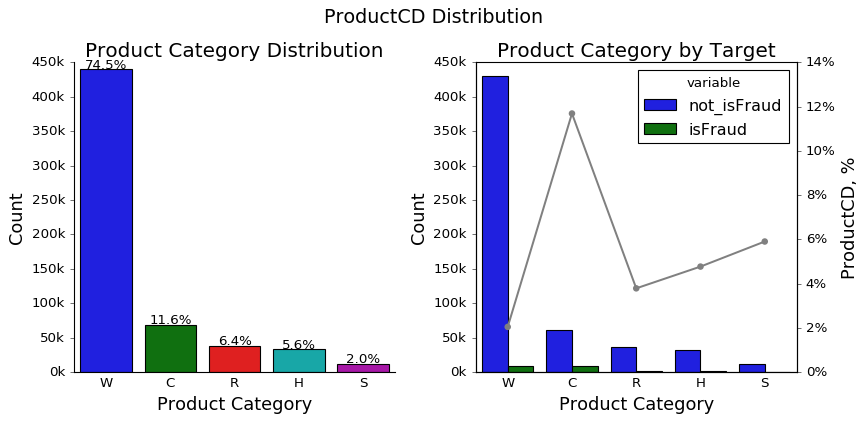

In [0]:
cat_graph(df_train_tr, 'ProductCD', 'isFraud', 'TransactionID')

# W, C and R categories are prevail in dataset
# C and S has the biggest share of fraud transactions, while W (the biggest category) - the lowest 

In [0]:
def cat_dist(df: pd.DataFrame, cat_col: str, target_col: str, cont_col: str,
             lim: int, miss=False, miss_val=False):
    '''
    Plot continious variable distribution ($) by category and binary target
    variable

    param df:
        Dataframe
    param cat_col:
        Category column name
    param target_col:
        Binary target column name
    param cont_col:
        Contnious variable (Money spend)
    param lim:
        Upper limit for cont_col if necessary
    param miss:
        Boolean, whether to treat NaN
    param miss_val:
        value to replace NaN
    '''

    # Prepare set for first chart  
    df_ = df.copy()
    if miss:
        df_[cat_col] = df_[cat_col].fillna(miss_val)
    fig, axs = plt.subplots(1, 1, figsize=(11, 5))
    fig.patch.set_facecolor('xkcd:white')
    fig.suptitle(f'{cat_col} Distribution', fontsize='x-large', y=1.05)
    plt.style.use('classic')
    
    # Order from biggest to smallest
    order = df_.groupby(cat_col)[cont_col].count().reset_index()\
        .sort_values(cont_col, ascending=False)\
        .reset_index(drop=True)[cat_col].to_list()

    def dollars(x, pos):
        return f'{x:.0f}$'

    ax = axs
    sns.boxenplot(x=cat_col, y=cont_col, hue=target_col,
                    data=df_[df_[cont_col] <= lim], order=order)
    ax.set_title(f'{cont_col} distribution by Category Type and Target')
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(dollars))
    ax.tick_params(axis='x', which='both', bottom=False, top=False)
    ax.tick_params(axis='y', which='both', right=False, direction='out')
    plt.legend(loc=2)
    plt.tight_layout()
    plt.show()

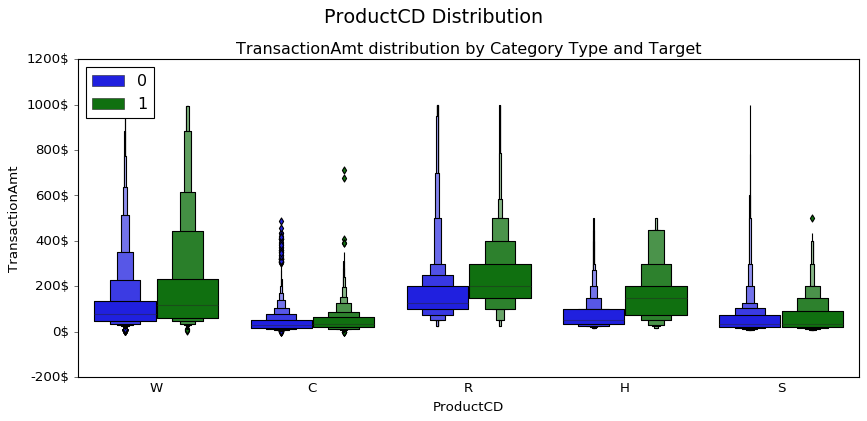

In [0]:
cat_dist(df_train_tr, 'ProductCD', 'isFraud', 'TransactionAmt', 1000)

## Card variables (card1 - card6)

In [0]:
resume_table[resume_table['Name'].isin(['card' + str(x) for x in range(1, 7)])]

# card4 and card6 are categorical variables
# card2 - card6 variables have missing values
# Let's investigate continiuos variables first

Name   dtypes  Missing  ...  Second value Third value Entropy
5   card1    int16        0  ...          2755        4663    9.97
6   card2  float16     8933  ...           404         490    6.32
7   card3  float16     1565  ...           150         150    0.68
8   card4   object     1577  ...    mastercard        visa    1.09
9   card5  float16     4259  ...           102         166    2.66
10  card6   object     1571  ...        credit       debit    0.82

[6 rows x 8 columns]

In [0]:
quan = [.01, .025, .1, .25, 0.5, 0.75, 0.9, 0.975, 0.99]
card_cont = df_train_tr[['card' + str(x) for x in range(1, 7) if x is not (4 or 6)]].quantile(quan)
card_cont

# card1 and card2 are right-skewed and therefore we may ceil max value or apply log transformation
# for card3 and card5 0.990 and 0.975 quantliers look very similar - 
# we may need to set up a ceil at 200 and 300 respectively

card1  card2  card3  card5
0.010   1338.0  100.0  144.0  102.0
0.025   1675.0  111.0  150.0  102.0
0.100   2803.0  111.0  150.0  126.0
0.250   6019.0  214.0  150.0  166.0
0.500   9678.0  361.0  150.0  226.0
0.750  14184.0  512.0  150.0  226.0
0.900  16582.1  555.0  150.0  226.0
0.975  18018.0  583.0  185.0  226.0
0.990  18238.0  583.0  185.0  226.0

In [0]:
def value_counts_remove(df: pd.DataFrame, col: str, lim_int: int, lim_cat=False):
    '''
    Remove low count values in categorical, ordinal, and semi-continuous 
    variables

    param df:
        Dataframe
    param col:
        column to squeeze
    param lim_int:
        limit target col by value (set manually by user)
    param lim_cat:
        if True take top lim_int value_count values

    '''

    df_ = df.copy()
    if lim_cat:
        df_.loc[df_[col].isin(df_[col].value_counts().iloc[lim_int:].index),
                                col] = 'others'
        return df_
    else:
        df_.loc[df_[col].isin(df_[col].value_counts()\
                            [df_[col].value_counts() <= lim_int].index),
                                col] = 'others'
        return df_

In [0]:
# We replace rare values from card3 and card5 by 'other' category
# Probably we should remain card3 and card5 categories (even if they are more rare than indicated values) 
# that have 'isFraud' rate higher 3.5% (or may choose another targer value)

df_train_tr = value_counts_remove(df_train_tr, 'card3', 200)
df_train_tr = value_counts_remove(df_train_tr, 'card5', 300)

In [0]:
def card_cont_graph(df: pd.DataFrame, columns_name: list, target_col: str):
    '''
    Plot continiuos variable distribution for binary classification tasks in
    respect to target variable equal to one or zero respectively
    
    param df:
        dataframe
    param columns_list:
        list of df continious variables ['variable_one', 'variable_two'] 
        to be plotted
    param target_col:
        Binary variable to split 

    '''
    fig, axs = plt.subplots(len(columns_name), 1, figsize=(11, 5))
    plt.rc('text', usetex=True)
    for number, var_col in enumerate(columns_name):
        fig.patch.set_facecolor('xkcd:white')
        plt.style.use('classic')
        if len(columns_name) == 1:
            ax=axs
        else: 
            ax = axs[number]
        ax = sns.distplot(df[df[target_col] == 0][var_col], label='No',
                    kde_kws={'color': 'g', 'lw': 3}, hist=False, ax=ax)
        
        ax = sns.distplot(df[df[target_col] == 1][var_col], label='Yes',
                    kde_kws={'color': 'r', 'lw': 3}, hist=False, ax=ax)
        ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
        ax.set_ylabel('Probability')
        ax.set_title(f'{var_col} variable distribution by {target_col} target')
        ax.axis(xmin=0)
        ax.legend(loc=2)
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


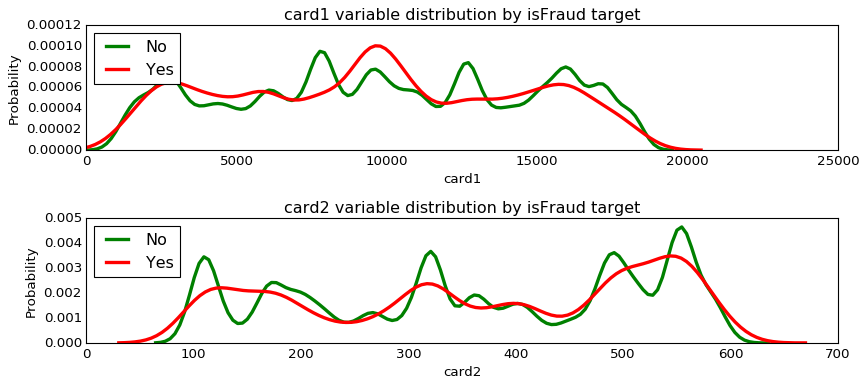

In [0]:
card_cont_graph(df_train_tr, ['card1', 'card2'], 'isFraud') 

In [0]:
def card_cat_graph(df: pd.DataFrame, var_col: str, target_col: str,
                   aggr_col: str, aggr_col_id: str):
    '''
    Plots categorical variable values, share of each caregory and % for binary 
    target variable

    param df:
        dataframe
    param var_col:
        Ordinal variable name 
    param target_col:
        Binary variable to split 
    param aggr_col:
        Aggregation column
    param aggr_col_id:
        ID column
        
    '''
    def floats_to_strings(x):
        'Converts floats to int'
        if isinstance(x, float):
            x = int(x)
        else:
            pass
        return x

    def millions(x, pos):
        'The two args are the value and tick position'
        x = (x * 1e-6)
        return f'${x:.0f}M'

    def thousands(x, pos):
        'The two args are the value and tick position'
        x = (x * 1e-3)
        return f'{x:.0f}K'

    def percentes(x, pos):
        'The two args are the value and tick position'
        x = (x * 1e2)
        return f'{x:.0f}%' 


    fig, axs = plt.subplots(2, 1, figsize=(12, 7))
    fig.patch.set_facecolor('xkcd:white')
    plt.style.use('classic')
    fig.suptitle(f'{var_col} Distribution', fontsize='x-large', y=1.05)
    df_ = df.copy()

    # create df for graph one
    n_target_col = 'not_' + target_col
    s_target_col = 'share_' + target_col
    t_share = 'share_total'

    card_df = df_.groupby(var_col)[aggr_col_id].count().reset_index()
    card_df.rename(columns={aggr_col_id: 'count'}, inplace=True)
    target_column = df_[df_[target_col] == 1].groupby(var_col)[aggr_col_id]\
                        .count().to_frame(name=target_col)
    card_df = card_df.join(target_column, sort=False, how='left', on=var_col)\
                        .fillna(0) 
    target_column = df_[df_[target_col] == 0].groupby(var_col)[aggr_col_id]\
                        .count().to_frame(name=n_target_col)
    card_df = card_df.join(target_column, sort=False, how='left', on=var_col)\
                        .fillna(0)    
    card_df[s_target_col] = card_df[target_col] / card_df['count']
    card_df[t_share] = card_df['count'] / card_df['count'].sum()
    card_df[var_col] = card_df[var_col].apply(floats_to_strings)
    tot_share = card_df[t_share]
    tot_share = round(tot_share * 100, 1).to_list()

    # draw graph one
    ax = axs[0]
    sns.barplot(x=var_col, y='count', data=card_df, ax=ax)
    sns.despine(top=True, right=False, left=False, bottom=False)
    ax.tick_params(axis='x', which='both', bottom=False, top=False)
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(thousands))
    for x_number, y_number in enumerate(tot_share):
        ax.text(x_number, card_df.loc[x_number, 'count'] + 3000,
                str(y_number), ha='center', fontsize=10)
    ax.set_ylabel('Count')
    ax.set_xlabel(f'{var_col} values')
    ax.set_title(f'{var_col} values distibution and % of Transaction frauds')
    ax.tick_params(axis='x', rotation=90)
    ax1 = ax.twinx()
    sns.pointplot(x=var_col, y=s_target_col, data=card_df, ax=ax1)
    sns.despine(top=True, right=False, left=False, bottom=False)
    ax1.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(percentes))
    ax1.set_ylabel('% of Fraud Transactions')

    # create df for graph two
    n_target_col = 'not_' + target_col
    s_target_col = 'share_' + target_col
    t_share = 'share_total' 

    df_[aggr_col] = df_[aggr_col].astype(np.float64) 
    card_df_ = df_.groupby(var_col)[aggr_col].sum().reset_index()
    card_df_.rename(columns={aggr_col: 'sum'},
                    inplace=True)
    target_column = df_[df_[target_col] == 1].groupby(var_col)[aggr_col]\
                        .sum().to_frame(name=target_col)
    card_df_ = card_df_.join(target_column, sort=False, how='left', on=var_col)\
                        .fillna(0) 
    target_column = df_[df_[target_col] == 0].groupby(var_col)[aggr_col]\
                        .sum().to_frame(name=n_target_col)
    card_df_ = card_df_.join(target_column, sort=False, how='left', on=var_col)\
                        .fillna(0)    
    card_df_[s_target_col] = card_df_[target_col] / card_df_['sum']
    card_df_[t_share] = card_df_['sum'] / card_df_['sum'].sum()
    card_df_[var_col] = card_df_[var_col].apply(floats_to_strings)
    tot_share = card_df_[t_share]
    tot_share = round(tot_share * 100, 1).to_list()

    # draw graph two
    ax = axs[1]
    sns.barplot(x=var_col, y='sum', data=card_df_, ax=ax)
    sns.despine(top=True, right=False, left=False, bottom=False)
    ax.tick_params(axis='x', which='both', bottom=False, top=False)
    ax.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(millions))
    for x_number, y_number in enumerate(tot_share):
        ax.text(x_number, card_df_.loc[x_number, 'sum'] + 3000,
                str(y_number), ha='center', fontsize=10)
    ax.set_ylabel('Amount')
    ax.set_xlabel(f'{var_col} values')
    ax.set_title(f'{var_col} values distibution and % of Transaction frauds')
    ax.tick_params(axis='x', rotation=90)
    ax1 = ax.twinx()
    sns.pointplot(x=var_col, y=s_target_col, data=card_df_, ax=ax1)
    sns.despine(top=True, right=False, left=False, bottom=False)
    ax1.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(percentes))
    ax1.set_ylabel('% of Fraud Transactions')
    plt.tight_layout()
    plt.show()
   

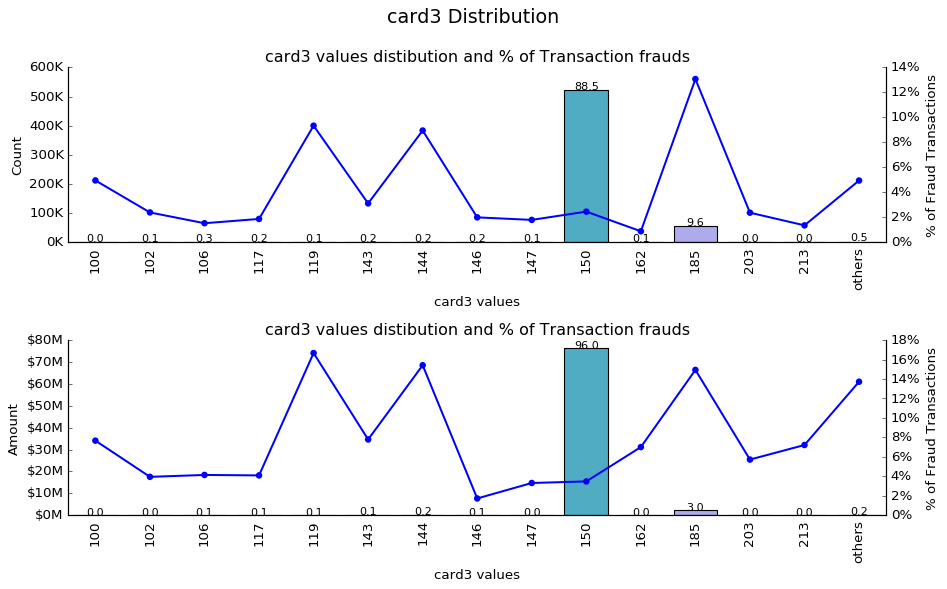

In [0]:
card_cat_graph(df_train_tr, 'card3', 'isFraud', 'TransactionAmt', 'TransactionID')

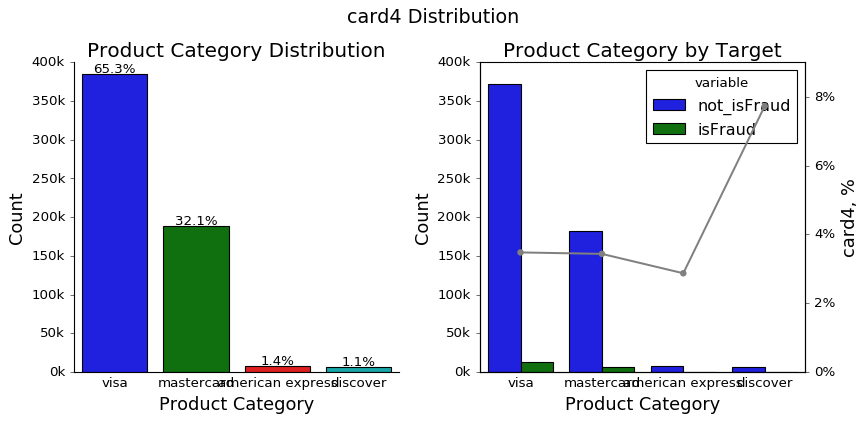

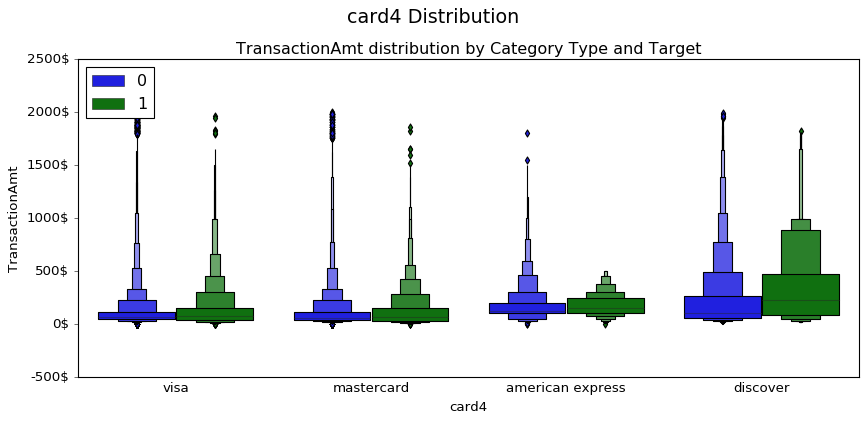

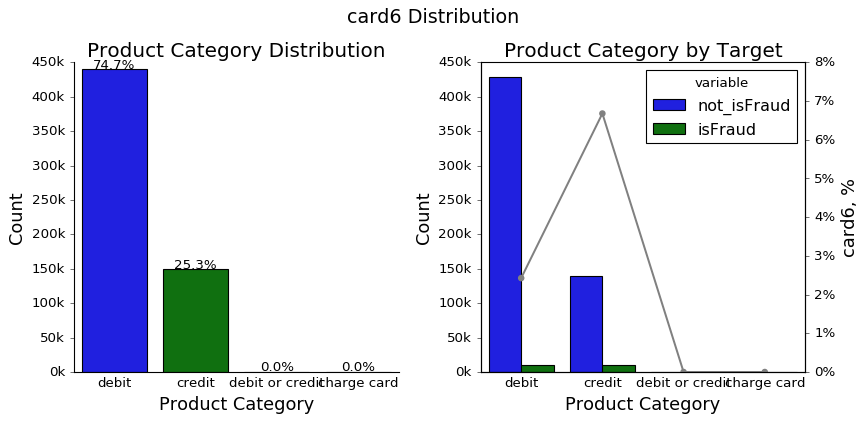

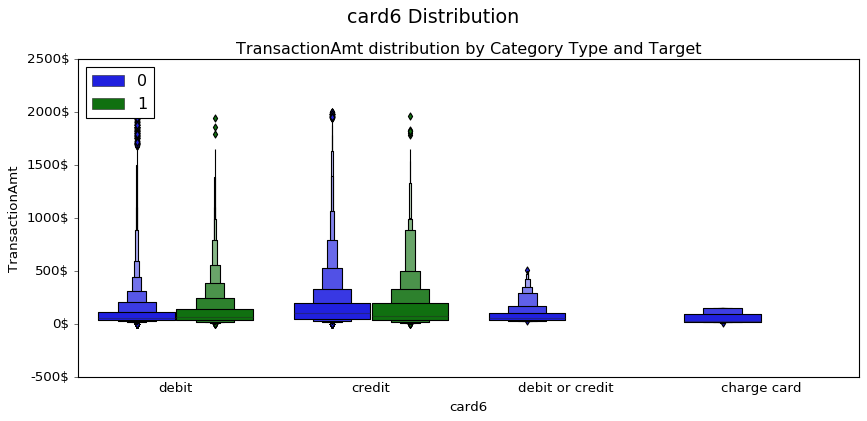

In [0]:
for var in ['card4', 'card6']:
    cat_graph(df_train_tr, var, 'isFraud', 'TransactionID')
    cat_dist(df_train_tr, var, 'isFraud', 'TransactionAmt', 2000)

## M variables (M1 - M9)

In [0]:
resume_table[resume_table['Name'].isin(['M'+ str(x) for x in range(15)])]

# Almost all of the are binary and have a lot of missing values

Name  dtypes  Missing  Unique First value Second value Third value  Entropy
46   M1  object   271100       2           T          NaN           T     0.00
47   M2  object   271100       2           T          NaN           T     0.49
48   M3  object   271100       2           T          NaN           T     0.75
49   M4  object   281444       3          M2           M0          M0     1.31
50   M5  object   350482       2           F            T           F     0.99
51   M6  object   169360       2           T            T           F     1.00
52   M7  object   346265       2         NaN          NaN           F     0.57
53   M8  object   346252       2         NaN          NaN           F     0.95
54   M9  object   346252       2         NaN          NaN           F     0.63

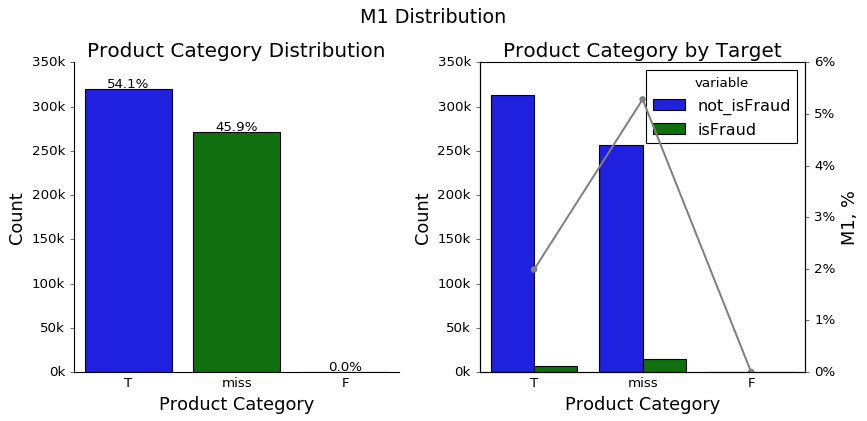

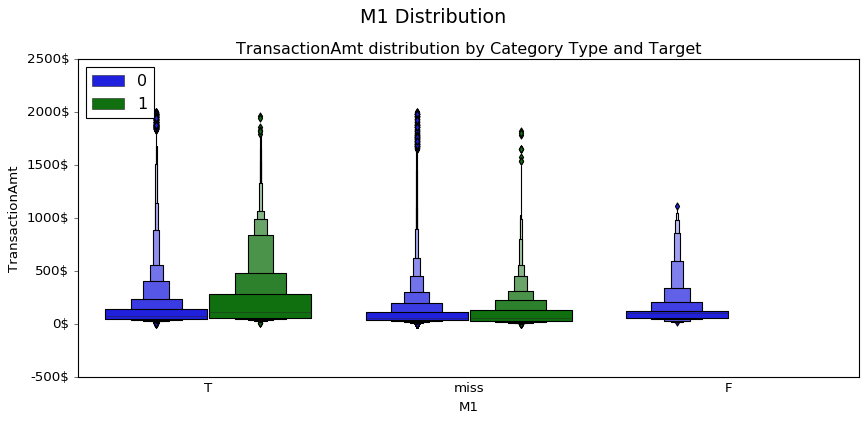

In [0]:
cat_graph(df_train_tr, 'M1', 'isFraud', 'TransactionID', miss=True, miss_val='miss')
cat_dist(df_train_tr, 'M1', 'isFraud', 'TransactionAmt', 2000, miss=True, miss_val='miss')

## Adress variable (addr1-addr2)

In [0]:
def geo_plot(df: pd.DataFrame, x: str, y: str, hue: str, size: str,
             lim=False, func=False):
    '''
    Plot graph on geolocation variables
    
    param df:
        DataFrame
    param x:
        First geolocation argument
    param y:
        Second geolocation argument
    param hue:
        Binary target variable to split
    param size:
        Continuous variable to vary dots size
    param lim:
        Upper limit for size variable if necessary
    param func:
        Apply function transformation to size variable if necessary

    '''
    # Prepare df
    df_ = df.copy()
    df_ = df_[df_[size] < 1000]
    df_[size] = df_[size].apply(func)
    df_ = df_[df_[size] > 0]
    
    # Plot setting
    fig, axs = plt.subplots(1, 1, figsize=(12, 7))
    fig.patch.set_facecolor('xkcd:white')
    plt.style.use('classic')

    # Plot
    sns.scatterplot(x=x, y=y, hue=hue, size=size,
                palette='ch:rot=-0.2,dark=0.3', data=df_)
    plt.show()

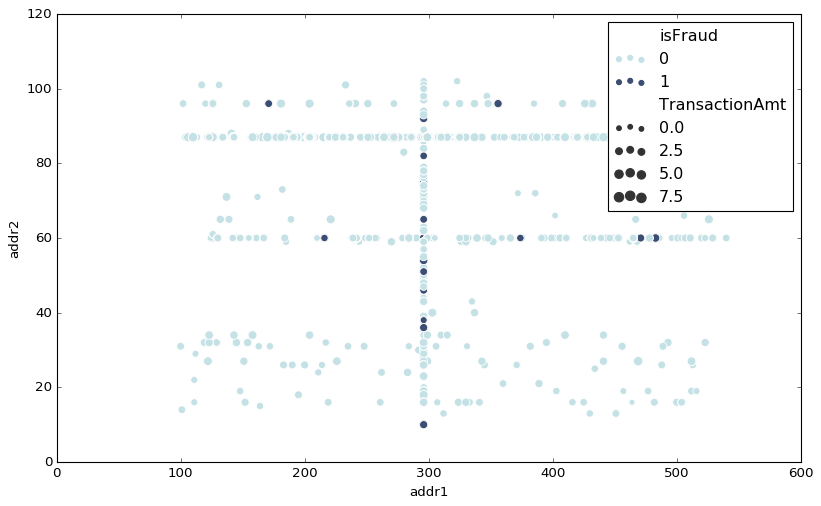

In [0]:
geo_plot(df_train_tr, 'addr1', 'addr2', 'isFraud', 'TransactionAmt', 1000, np.log)

# Seems like a living district and fraud transaction occurs only along lines

In [0]:
# Squeeze 'addr1' and 'addr2' semi-continuous variables

df_train_tr = value_counts_remove(df_train_tr, 'addr1', 5000)
df_train_tr = value_counts_remove(df_train_tr, 'addr2', 50)

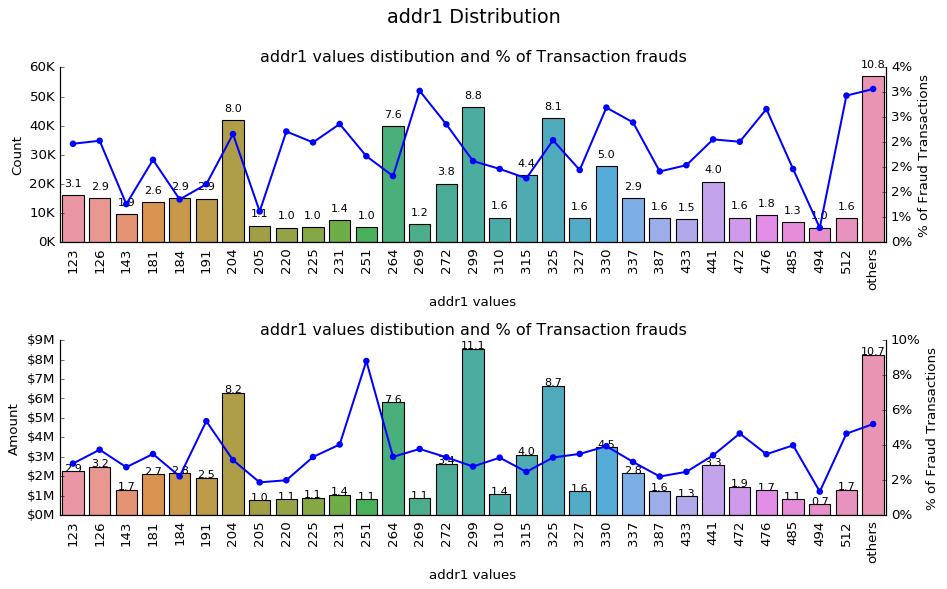

In [0]:
card_cat_graph(df_train_tr, 'addr1', 'isFraud', 'TransactionAmt', 'TransactionID')

# Several values are prevail in 'addr1' (as we can see in scatterplot they form lines)
# $ amount distribution have almost the same distibution for values except for point 299

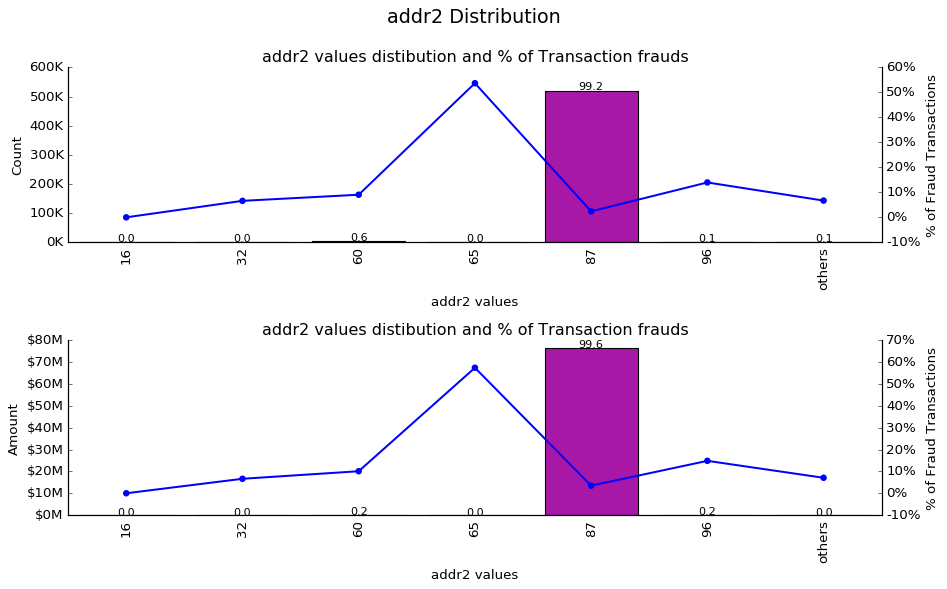

In [0]:
card_cat_graph(df_train_tr, 'addr2', 'isFraud', 'TransactionAmt', 'TransactionID')

# Point 87 - the most common value, near 99.5%
# Point 65 has fraud share at 60%

## Email variables (emaildomain)

In [0]:
def email_split(df: pd.DataFrame, em_col: str):
    '''
    Split email adress highlightning server and region separatly

    param df:
        Dataframe
    param em_col:
        column with email adresses in it
    '''

    df_ = df.copy()
    if em_col in df_.columns:
        email_columns = df_[df_[em_col].isnull() == False][em_col]\
                            .apply(lambda x: x.split('.', 2))
        for line in email_columns:
            if len(line) < 2:
                line.append(np.nan)
        server = pd.Series(email_columns.apply(lambda x: x[0]))
        region = pd.Series(email_columns.apply(lambda x: x[1]))
        res = pd.concat([server, region], axis=1, sort=False)
        res.columns = [em_col + '_server', em_col + '_region'] 
        idx = df_.columns.get_loc(em_col) 
        df_ = pd.concat([df_.iloc[:, :idx], res.iloc[:, :], df_.iloc[:, idx + 1:]], axis=1, sort=False)
    return df_

In [0]:
print(df_train_tr.shape)
df_train_tr = email_split(df_train_tr, 'P_emaildomain')
print(df_train_tr.shape)
df_train_tr = email_split(df_train_tr, 'R_emaildomain')
print(df_train_tr.shape)

(590540, 394)
(590540, 395)
(590540, 396)


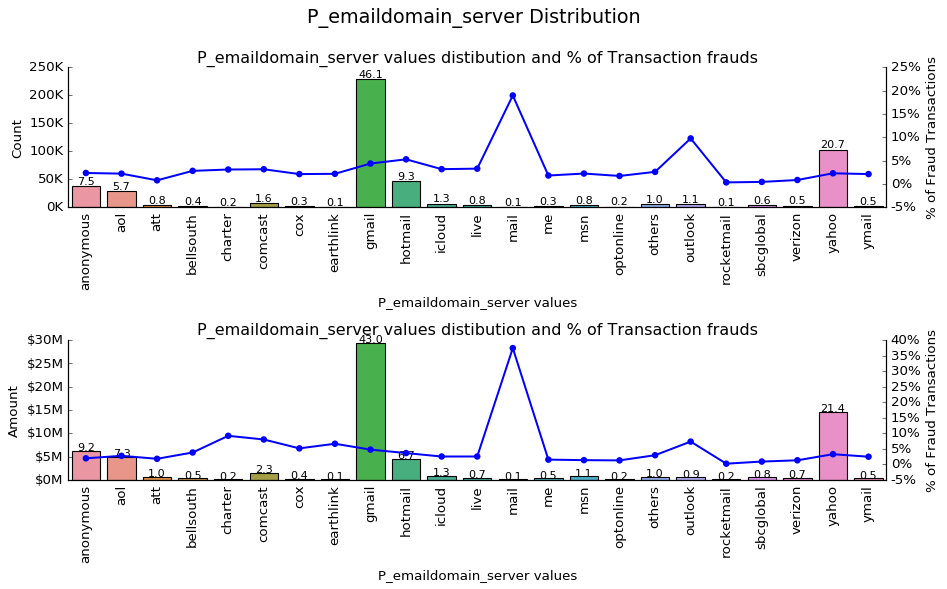

In [0]:
df_train_tr = value_counts_remove(df_train_tr, 'P_emaildomain_server', 500)
card_cat_graph(df_train_tr, 'P_emaildomain_server', 'isFraud', 'TransactionAmt', 'TransactionID')

# Google, yahoo and hotmail are the most popular email domains
# Transactions from Mail and Outlook domain have significantly higher % of frauds 

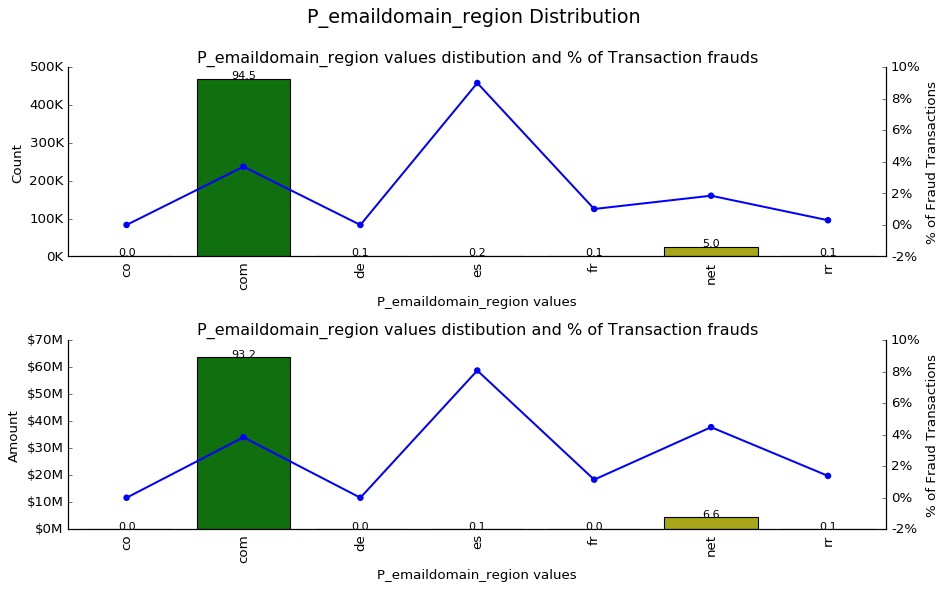

In [0]:
card_cat_graph(df_train_tr, 'P_emaildomain_region', 'isFraud', 'TransactionAmt', 'TransactionID')

# .com region is dominant ~ 94% in both quantity and amount of transactions

## C1 - C14 variables

In [0]:
c_values_list = ['C' + str(x) for x in range(1, 15)]
for c_cat in c_values_list:
    df_train_tr = value_counts_remove(df_train_tr, c_cat, 20, lim_cat=True)

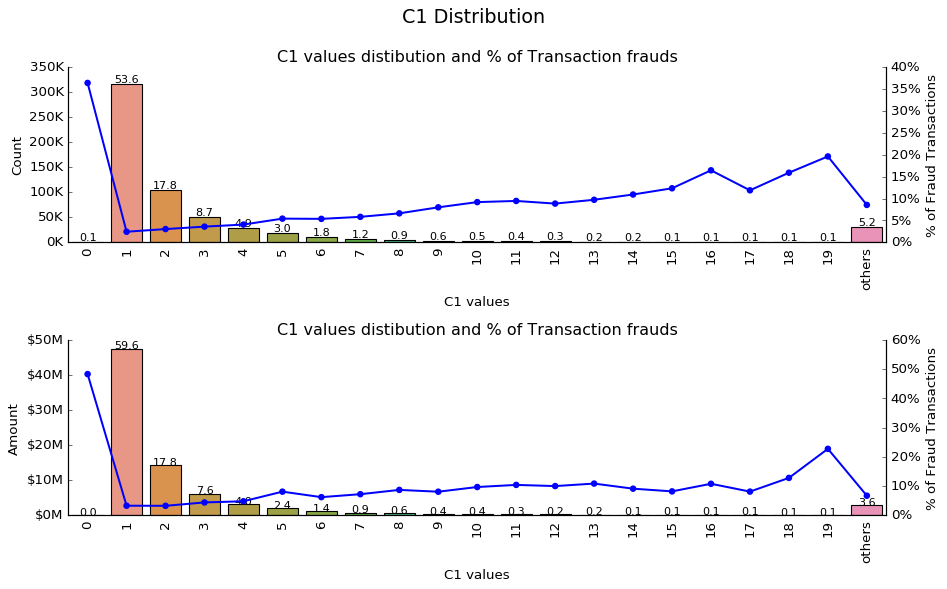

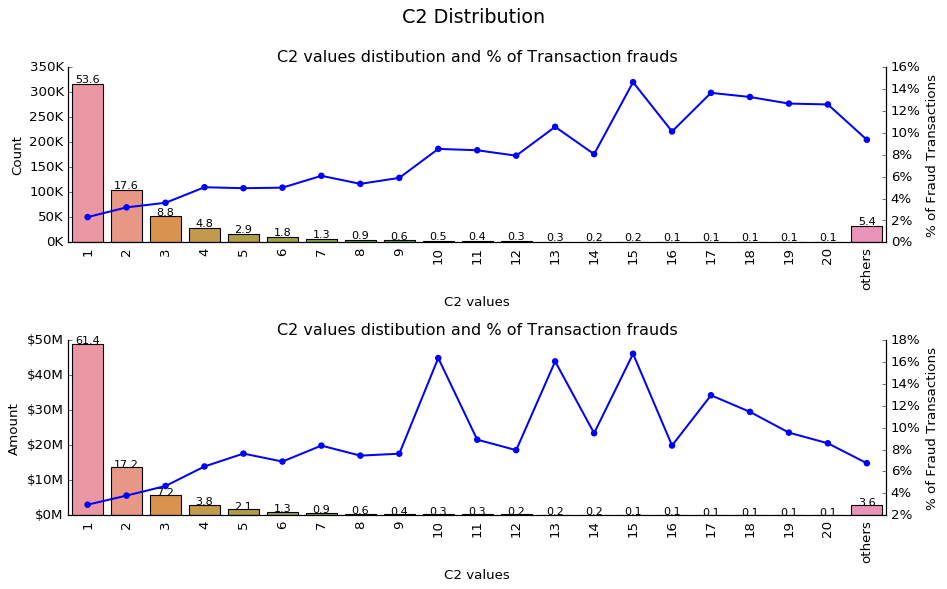

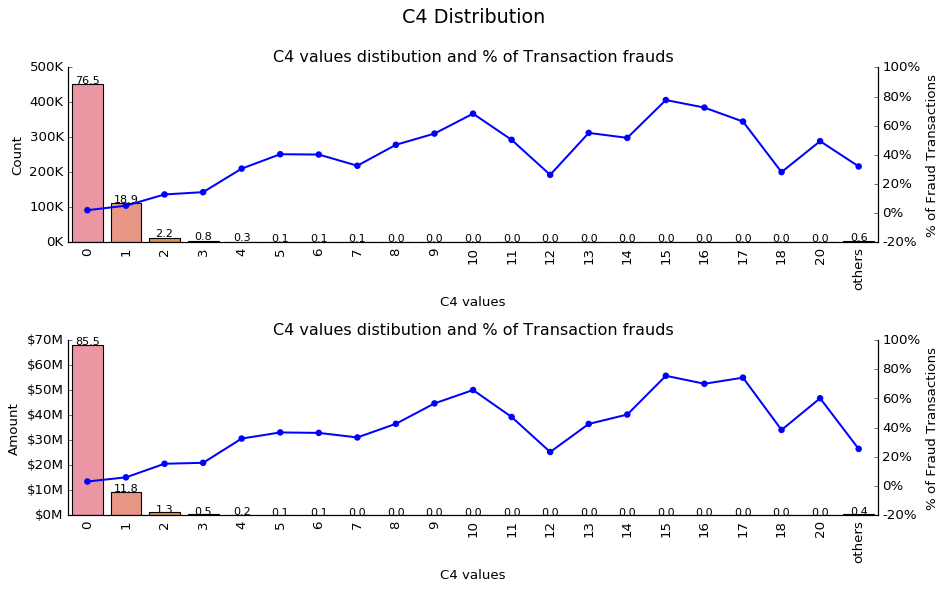

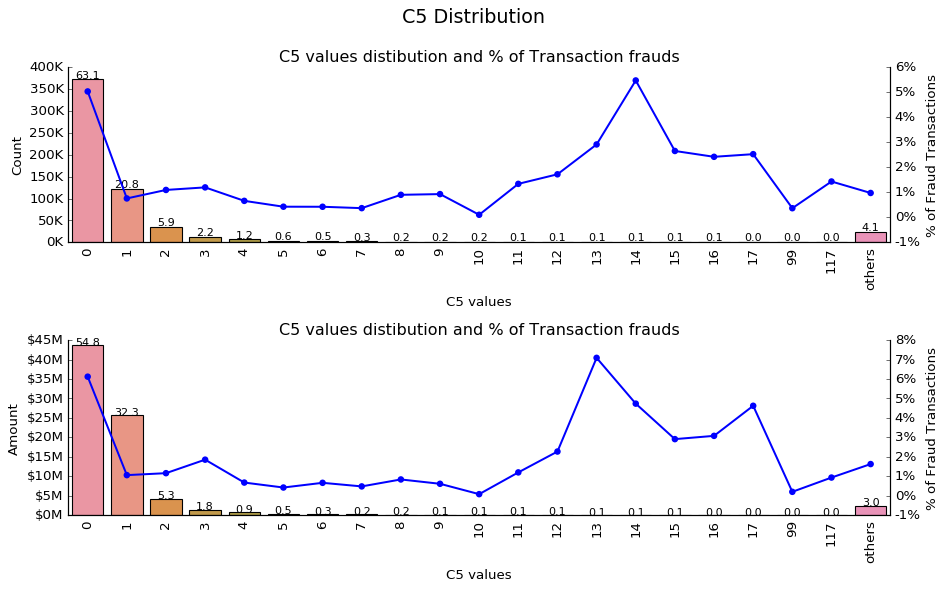

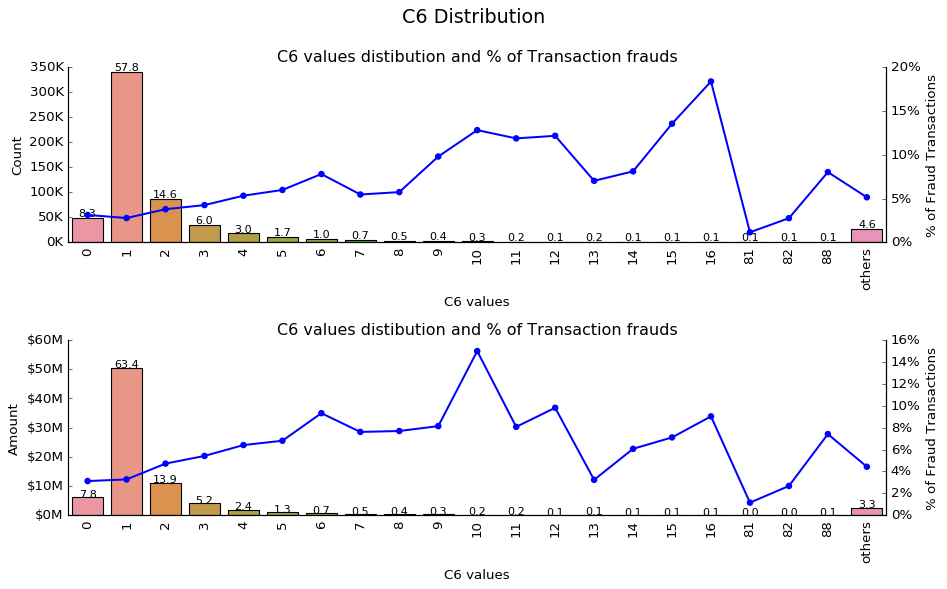

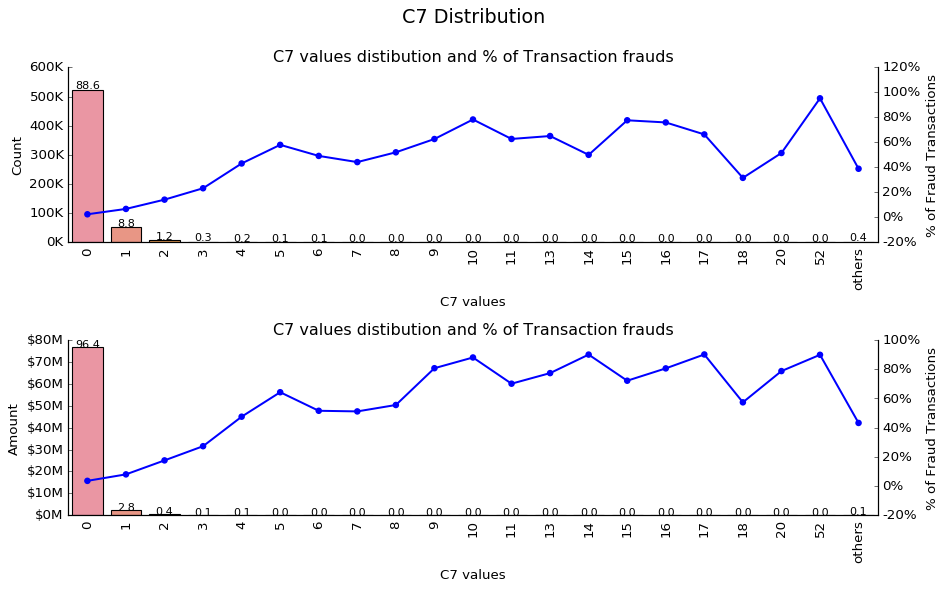

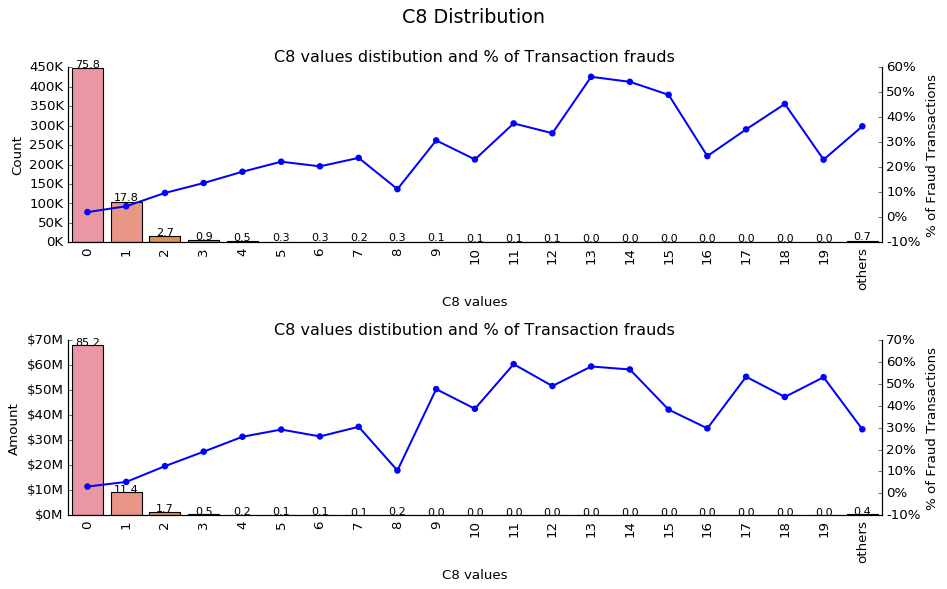

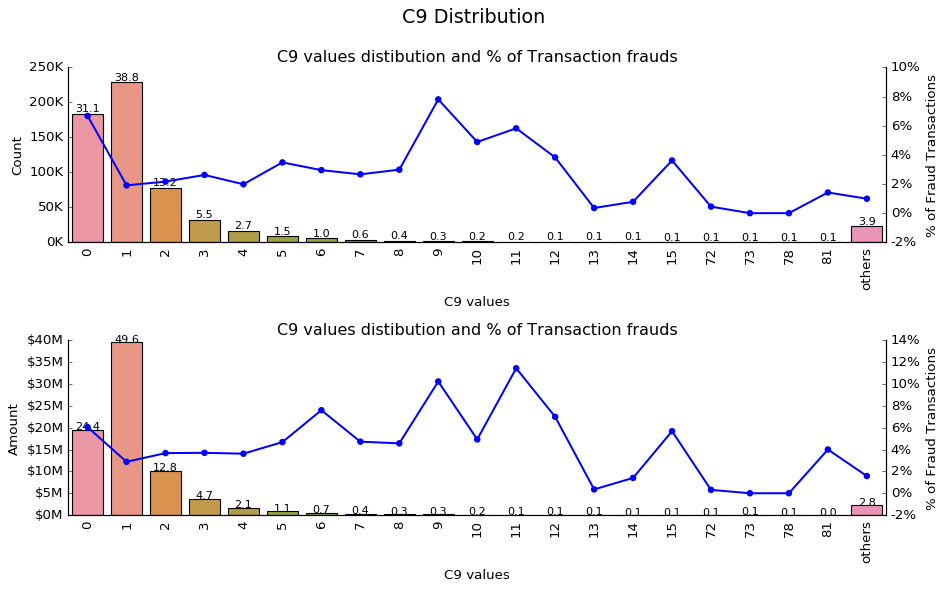

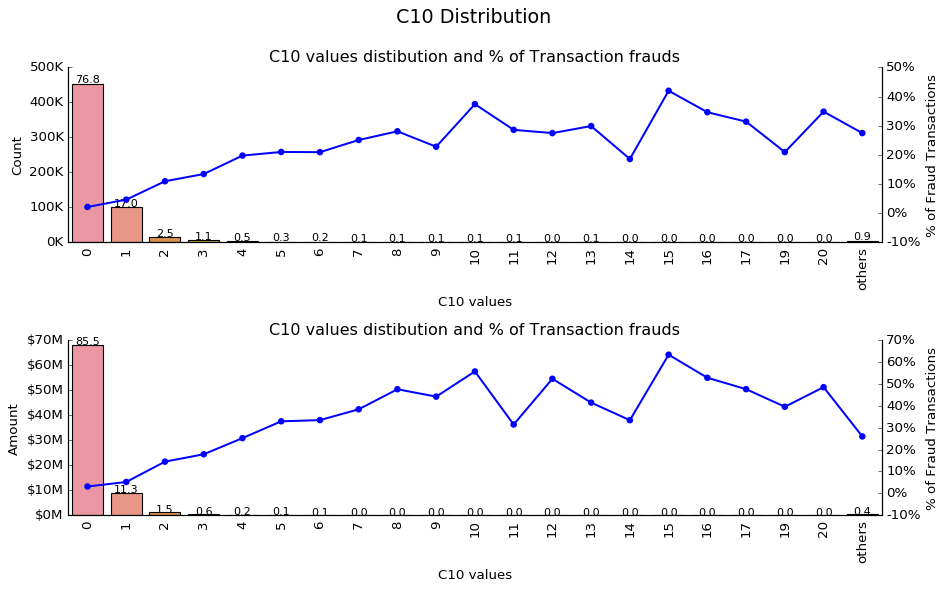

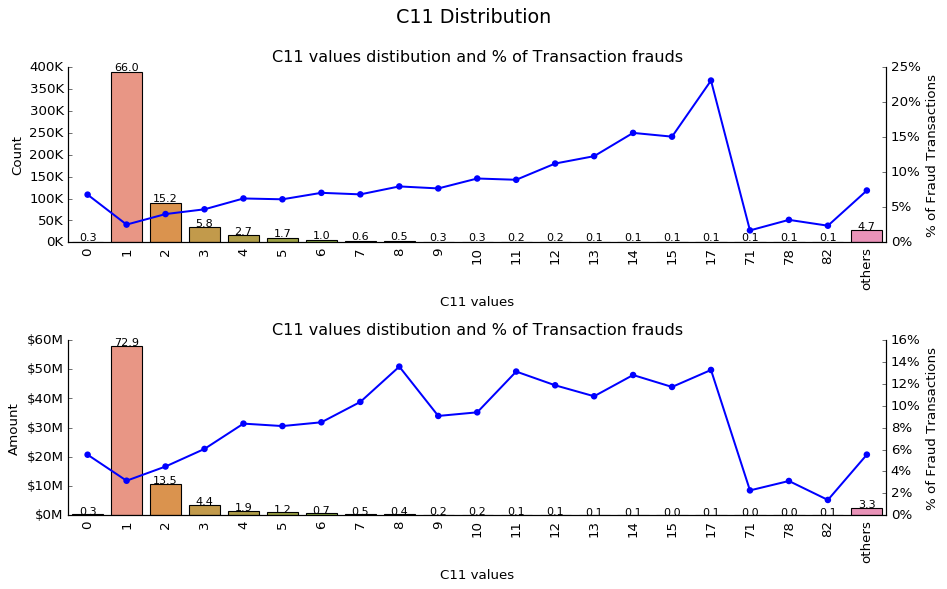

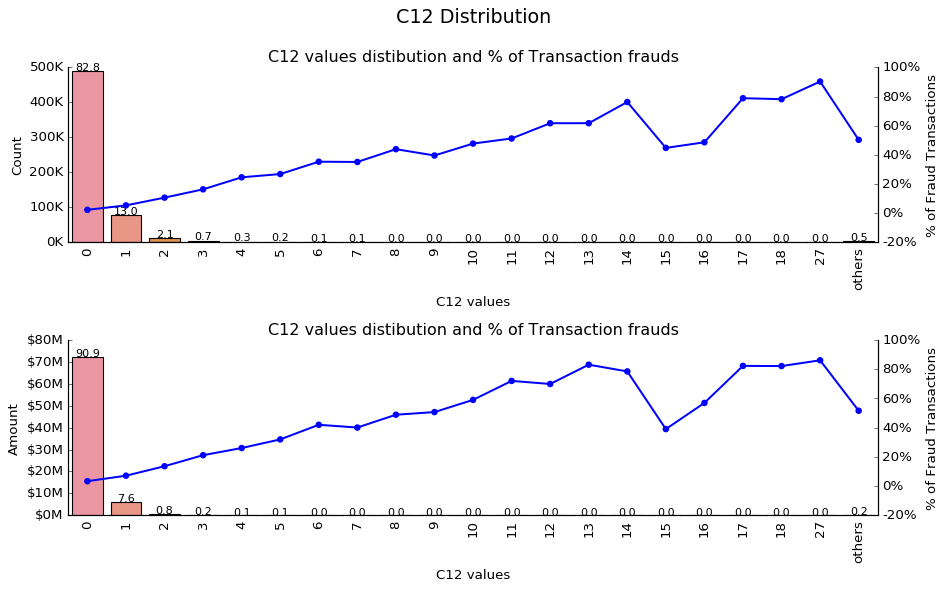

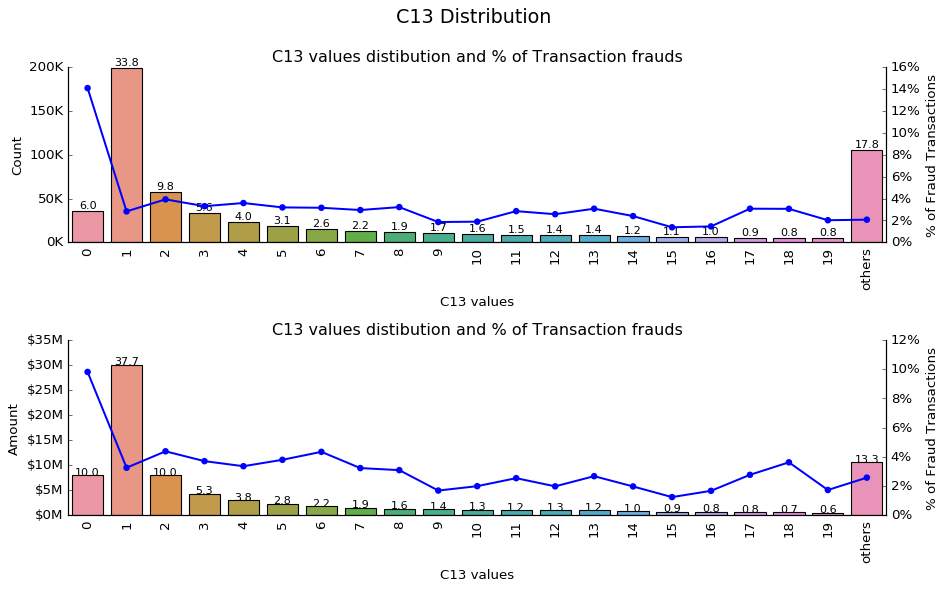

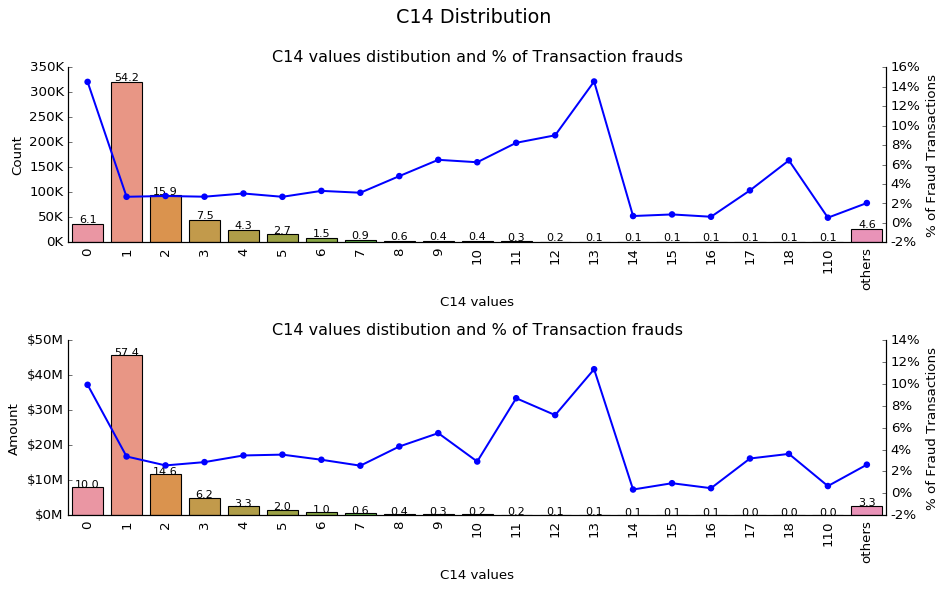

In [0]:
c_values_list = ['C' + str(x) for x in range(1, 15) if x !=3]
for c_cat in c_values_list:
    card_cat_graph(df_train_tr, c_cat, 'isFraud', 'TransactionAmt', 'TransactionID')

## Time features

In [0]:
def date_extraction(df: pd.DataFrame, data:str ):
    '''
    If data presented as np.int we may extract days, weeks, houres and so on

    param df:
        Dataframe
    param data:
        Column that contain data 

    '''
    df_ = df.copy()
    day_of_week = np.floor(df_[data] /  (60 * 60 * 24) % 7)
    day_of_month = (np.floor(df_[data] /  (60 * 60 * 24) % 31) + 1)
    hours = (np.floor(df_[data] /  (60 * 60) % 24) + 1)
    minutes = (np.floor(df_[data] /  (60) % 60) + 1)
    res = pd.concat([day_of_week, day_of_month, hours, minutes], axis=1)
    res.columns = ['day_of_week', 'day_of_month', 'hourse', 'minutes']
    idx = df_.columns.get_loc(data)
    df_ = pd.concat([df_.iloc[:, :idx], res.iloc[:, :], df_.iloc[:, idx + 1:]],
                    axis=1, sort=False)

    return df_


In [0]:
X_train['Transaction']

In [0]:
print(df_train_tr.shape)
df_train_tr = date_extraction(df_train_tr, 'TransactionDT')
print(df_train_tr.shape)

(590540, 396)
(590540, 401)


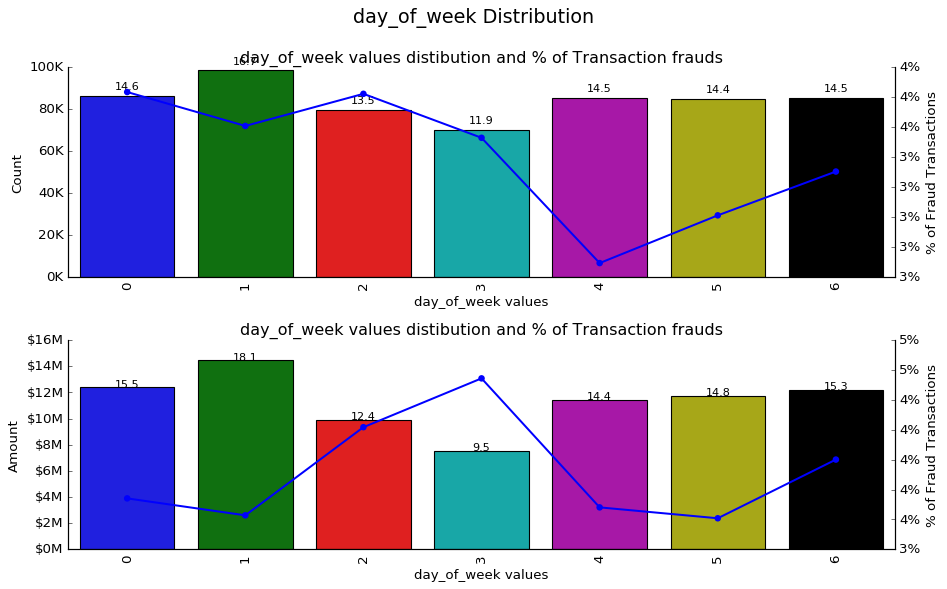

In [0]:
card_cat_graph(df_train_tr, 'day_of_week', 'isFraud', 'TransactionAmt', 'TransactionID')

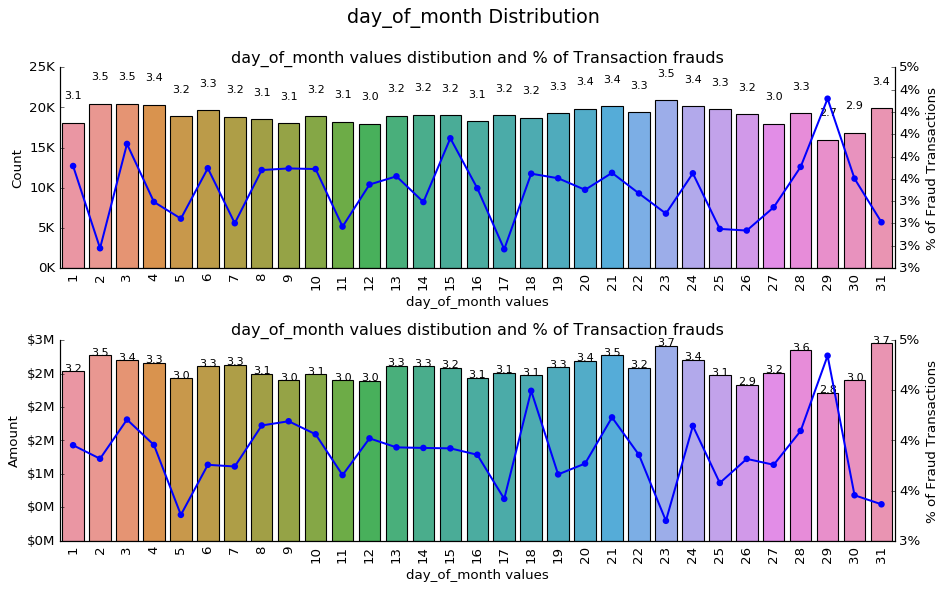

In [0]:
card_cat_graph(df_train_tr, 'day_of_month', 'isFraud', 'TransactionAmt', 'TransactionID')

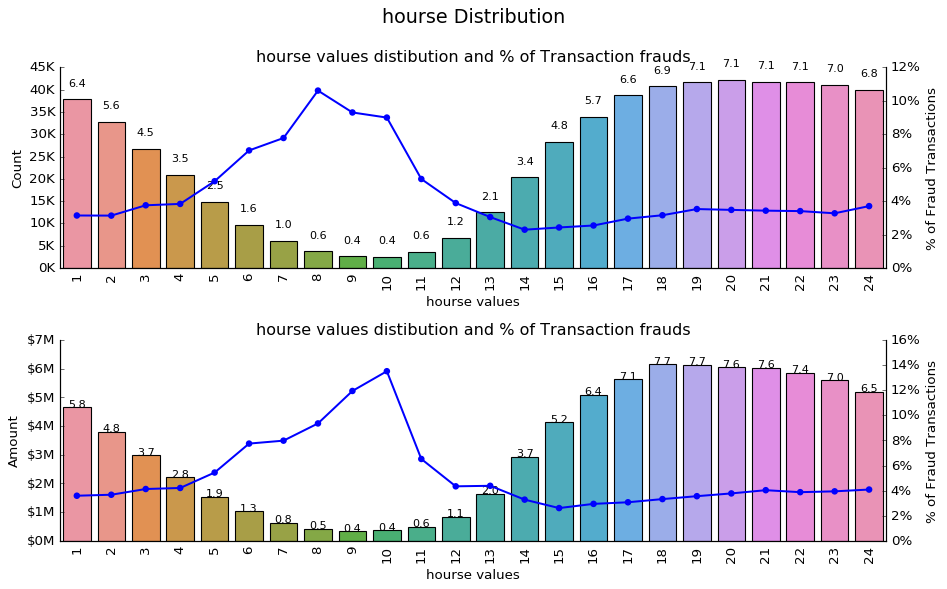

In [0]:
card_cat_graph(df_train_tr, 'hourse', 'isFraud', 'TransactionAmt', 'TransactionID')

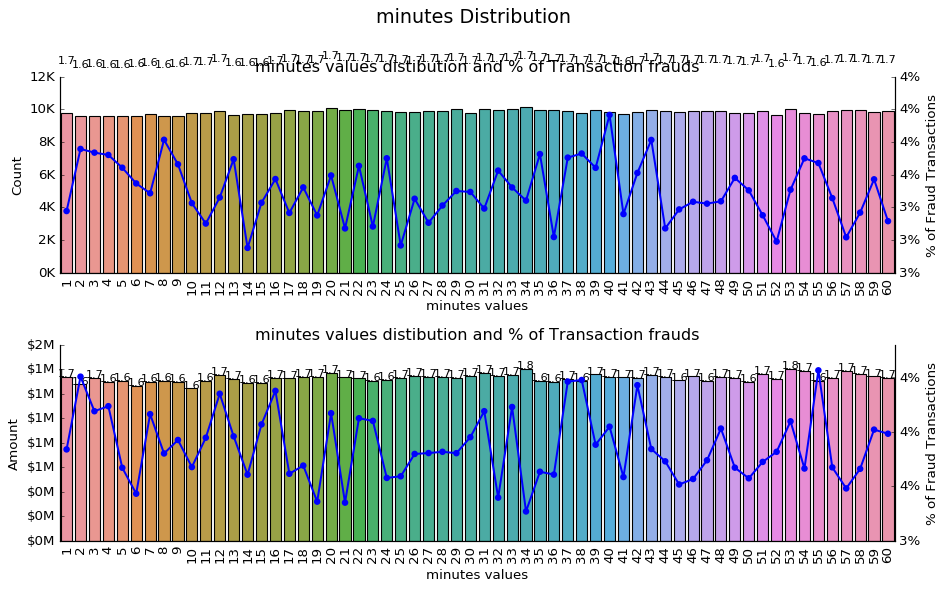

In [0]:
card_cat_graph(df_train_tr, 'minutes', 'isFraud', 'TransactionAmt', 'TransactionID')

## Identity variables

In [0]:
df_train_id.head()

TransactionID  id_01  ...  DeviceType                     DeviceInfo
0        2987004    0.0  ...      mobile  SAMSUNG SM-G892A Build/NRD90M
1        2987008   -5.0  ...      mobile                     iOS Device
2        2987010   -5.0  ...     desktop                        Windows
3        2987011   -5.0  ...     desktop                            NaN
4        2987016    0.0  ...     desktop                          MacOS

[5 rows x 41 columns]

### Operation system

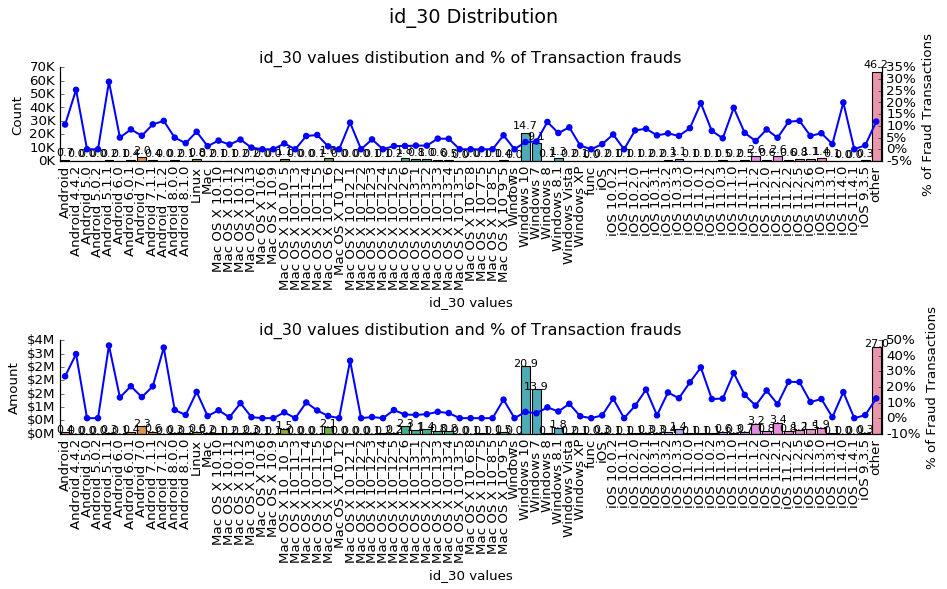

In [0]:
a = pd.merge(df_train_tr[['TransactionID', 'TransactionAmt', 'isFraud']], df_train_id[['TransactionID', 'id_30']], on='TransactionID')
a.fillna('other', inplace=True)
card_cat_graph(a, 'id_30', 'isFraud', 'TransactionAmt', 'TransactionID')

In [0]:
df_train_id.loc[df_train_id['id_30'].str.contains('Windows', na=False), 'id_30'] = 'Windows'
df_train_id.loc[df_train_id['id_30'].str.contains('Android', na=False), 'id_30'] = 'Android'
df_train_id.loc[df_train_id['id_30'].str.contains('Linux', na=False), 'id_30'] = 'Linux'
df_train_id.loc[df_train_id['id_30'].str.contains('Mac', na=False), 'id_30'] = 'Mac OS'
df_train_id.loc[df_train_id['id_30'].str.contains('func', na=False), 'id_30'] = 'func'
df_train_id.loc[df_train_id['id_30'].str.contains('iOS', na=False), 'id_30'] = 'iOS'
df_train_id['id_30'].fillna('other', inplace=True)

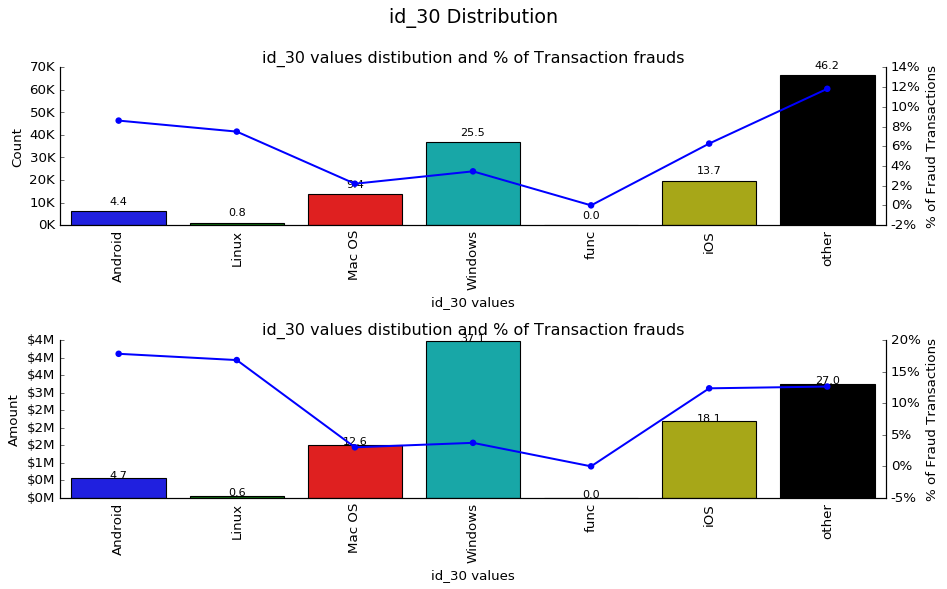

In [0]:
a = pd.merge(df_train_tr[['TransactionID', 'TransactionAmt', 'isFraud']], df_train_id[['TransactionID', 'id_30']], on='TransactionID')
card_cat_graph(a, 'id_30', 'isFraud', 'TransactionAmt', 'TransactionID')

### Browser variable

In [0]:
df_train_id.loc[df_train_id['id_31'].str.contains('chrome',
                                                  na=False), 'id_31'] = 'Chrome'
df_train_id.loc[df_train_id['id_31'].str.contains('firefox',
                                                  na=False), 'id_31'] = 'Firefox'
df_train_id.loc[df_train_id['id_31'].str.contains('safari',
                                                  na=False), 'id_31'] = 'Safari'
df_train_id.loc[df_train_id['id_31'].str.contains('edge',
                                                  na=False), 'id_31'] = 'Edge'
df_train_id.loc[df_train_id['id_31'].str.contains('ie',
                                                  na=False), 'id_31'] = 'IE'
df_train_id.loc[df_train_id['id_31'].str.contains('samsung',
                                                  na=False), 'id_31'] = 'Samsung'
df_train_id.loc[df_train_id['id_31'].str.contains('opera',
                                                  na=False), 'id_31'] = 'Opera'
df_train_id['id_31'].fillna("NAN", inplace=True)
df_train_id.loc[df_train_id['id_31'].isin(df_train_id['id_31'].value_counts()\
                                          [df_train_id['id_31'].value_counts()\
                                           < 200].index), 'id_31'] = "Others"

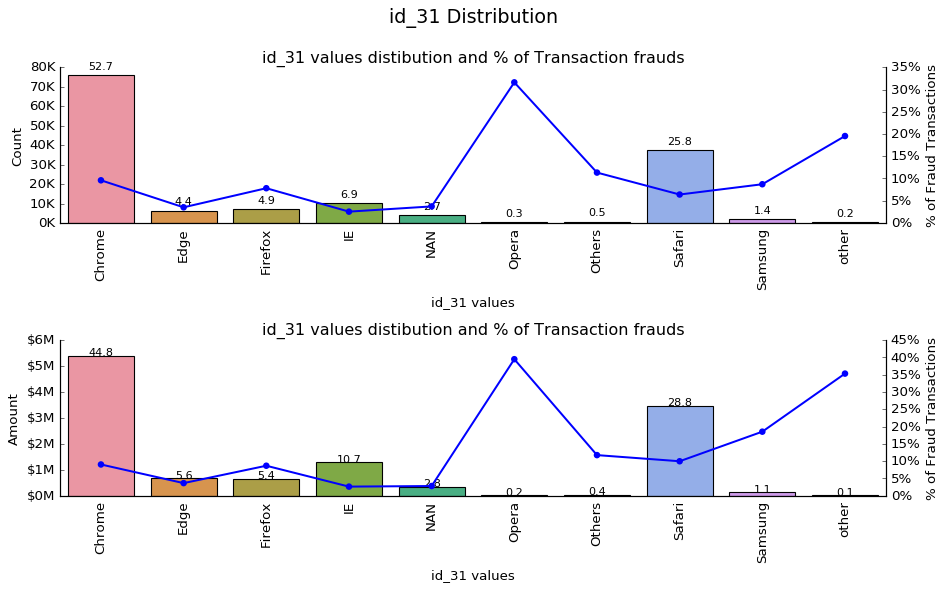

In [0]:
a = pd.merge(df_train_tr[['TransactionID', 'TransactionAmt', 'isFraud']],
             df_train_id[['TransactionID', 'id_31']], on='TransactionID')
card_cat_graph(a, 'id_31', 'isFraud', 'TransactionAmt', 'TransactionID')

### Screen size of a device 

In [0]:
def column_screen_split(df: pd.DataFrame, col_to_split: str):
    '''

    '''
    df_ = df.copy()
    splits = df_.loc[:, col_to_split].apply(lambda x: x.split('x', 2) \
                                            if x is not np.nan \
                                            else [np.nan, np.nan])
    var_0 = splits.apply(lambda x: float(x[0]) if x is not np.nan else np.nan)
    var_1 = splits.apply(lambda x: float(x[1]) if x is not np.nan else np.nan)
    res = pd.concat([var_0, var_1], axis=1, sort=False)
    res.columns = ['length', 'height']
    idx = df_.columns.get_loc(col_to_split)
    df_ = pd.concat([df_.iloc[:, :idx], res.iloc[:, :], df_.iloc[:, idx + 1:]],
                    axis=1, sort=False)
    return df_

In [0]:
print(df_train_id.shape)
a = column_screen_split(df_train_id, 'id_33')
print(a.shape)

(144233, 41)
(144233, 42)


In [0]:
screen = df_train_id['id_33'].apply(lambda x: x.split('x') if x is not np.nan else np.nan)
lenght = screen.apply(lambda x: float(x[0]) if x is not np.nan else np.nan)
width = screen.apply(lambda x: float(x[1]) if x is not np.nan else np.nan)
screen = pd.concat([lenght, width], axis=1)
screen.columns = ['length', 'width']
screen_id = pd.concat([df_train_id['TransactionID'], screen], axis=1,
                      names=['TransactionID', 'length', 'width'])

a = pd.merge(df_train_tr[['TransactionID', 'TransactionAmt', 'isFraud']],
             screen_id[['TransactionID', 'length', 'width']], on='TransactionID')

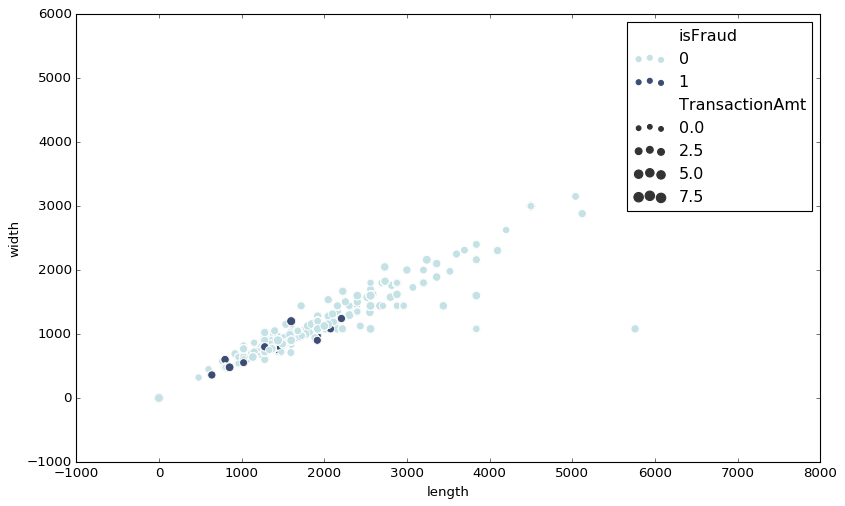

In [0]:
geo_plot(a, 'length', 'width', 'isFraud', 'TransactionAmt', 1000, np.log)

# Fraud operations are more often conducted from devices with smaller screens 

### Missing values visualization

In [0]:
msno.matrix(X_train.loc[:, cols_to_transform])
plt.show()

## Category Encoding scheme

In [0]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from scipy.stats import rankdata

class Model:
    def __init__(self, encoders_names=None, cat_cols=None,
                 model_validation=StratifiedKFold(n_splits=2, shuffle=False, random_state=42),
                 model_params=None):
        self.encoders_names = encoders_names
        self.cat_cols = cat_cols
        self.model_validation = model_validation

        if model_params is None:
            self.model_params = {"loss_function": "Logloss", "iterations": 200,
                                 "task_type": 'GPU', "devices": '0:1',
                                 'custom_metric': 'AUC', 'depth': 5, 
                                 'learning_rate': 0.03, 'metric_period': 200,
                                 'early_stopping_rounds': 50}
        else:
            self.model_params = model_params

        self.encoders_list = []
        self.models_list = []
        self.scores_list_train = []
        self.scores_list_val = []
        self.models_trees = []

    def fit(self, X: pd.DataFrame, y: np.array) -> tuple:

        for n_fold, (train_idx, val_idx) in enumerate(self.model_validation.split(X, y)):
            X_train, X_val = X.loc[train_idx].reset_index(drop=True), X.loc[val_idx].reset_index(drop=True)
            y_train, y_val = y[train_idx], y[val_idx]
            print(f"shapes before encoder : ", X_train.shape, X_val.shape)
            
            encoder = DoubleValidationEncoderNumerical(cols=self.cat_cols, encoders_names_tuple=self.encoders_names)
            X_train = encoder.fit_transform(X_train, y_train)
            X_val = encoder.transform(X_val)
            self.encoders_list.append(encoder)
            
            # check for OrdinalEncoder encoding
            for col in [col for col in X_train.columns if "OrdinalEncoder" in col]:
                X_train[col] = X_train[col].astype("category")
                X_val[col] = X_val[col].astype("category")

            
            # fit model
            print(f"shapes before model : ", X_train.shape, X_val.shape)
            model = CatBoostClassifier(**self.model_params)
            model.fit(X_train, y_train, eval_set=(X_val, y_val))
            self.models_trees.append(model.get_best_iteration())
            self.models_list.append(model)

            y_hat = model.predict_proba(X_train)[:, 1]
            score_train = roc_auc_score(y_train, y_hat)
            self.scores_list_train.append(score_train)
            y_hat = model.predict_proba(X_val)[:, 1]
            score_val = roc_auc_score(y_val, y_hat)
            self.scores_list_val.append(score_val)

            print(f"AUC on {n_fold} fold train : {np.round(score_train, 4)}\n\n ")
            print(f"AUC on {n_fold} fold val : {np.round(score_val, 4)}\n\n ")

        mean_score_train = np.mean(self.scores_list_train)
        mean_score_val = np.mean(self.scores_list_val)
        avg_num_trees = int(np.mean(self.models_trees))
        print(f"\n\n Mean score train : {np.round(mean_score_train, 4)} ")
        print(f"\n\n Mean score val : {np.round(mean_score_val, 4)}\n\n ")
        return mean_score_train, mean_score_val, avg_num_trees

    def predict(self, X: pd.DataFrame) -> np.array:
        y_hat = np.zeros(X.shape[0])
        for encoder, model in zip(self.encoders_list, self.models_list):
            X_test = X.copy()
            X_test = encoder.transform(X_test)

            # check for OrdinalEncoder encoding
            for col in [col for col in X_test.columns if "OrdinalEncoder" in col]:
                X_test[col] = X_test[col].astype("category")

            unranked_preds = model.predict_proba(X_test)[:, 1]
            y_hat += rankdata(unranked_preds)
        return y_hat, X_test.shape[1]

In [0]:
import numpy as np
import pandas as pd
from typing import List

from category_encoders.ordinal import OrdinalEncoder
from category_encoders.woe import WOEEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.sum_coding import SumEncoder
from category_encoders.m_estimate import MEstimateEncoder
from category_encoders.backward_difference import BackwardDifferenceEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from category_encoders.helmert import HelmertEncoder
from category_encoders.cat_boost import CatBoostEncoder
from category_encoders.james_stein import JamesSteinEncoder
from category_encoders.one_hot import OneHotEncoder

from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold

def get_single_encoder(encoder_name: str, cat_cols: list): 
    """
    Get encoder by its name
    :param encoder_name: Name of desired encoder
    :param cat_cols: Cat columns for encoding
    :return: Categorical encoder
    """
    if encoder_name == "FrequencyEncoder":
        encoder = FrequencyEncoder(cols=cat_cols)

    if encoder_name == "WOEEncoder":
        encoder = WOEEncoder(cols=cat_cols)

    if encoder_name == "TargetEncoder":
        encoder = TargetEncoder(cols=cat_cols)

    if encoder_name == "SumEncoder":
        encoder = SumEncoder(cols=cat_cols)

    if encoder_name == "MEstimateEncoder":
        encoder = MEstimateEncoder(cols=cat_cols)

    if encoder_name == "LeaveOneOutEncoder":
        encoder = LeaveOneOutEncoder(cols=cat_cols)

    if encoder_name == "HelmertEncoder":
        encoder = HelmertEncoder(cols=cat_cols)

    if encoder_name == "BackwardDifferenceEncoder":
        encoder = BackwardDifferenceEncoder(cols=cat_cols)

    if encoder_name == "JamesSteinEncoder":
        encoder = JamesSteinEncoder(cols=cat_cols)

    if encoder_name == "OrdinalEncoder":
        encoder = OrdinalEncoder(cols=cat_cols)

    if encoder_name == "CatBoostEncoder":
        encoder = CatBoostEncoder(cols=cat_cols)

    if encoder_name == "MEstimateEncoder":
        encoder = MEstimateEncoder(cols=cat_cols)
    return encoder



class DoubleValidationEncoderNumerical:
    """
    Encoder with validation within
    """
    def __init__(self, cols, encoders_names_tuple=()):
        """
        :param cols: Categorical columns
        :param encoders_names_tuple: Tuple of str with encoders
        """
        self.cols, self.num_cols = cols, None
        self.encoders_names_tuple = encoders_names_tuple

        self.n_folds, self.n_repeats = 5, 2
        self.model_validation = RepeatedStratifiedKFold(n_splits=self.n_folds, n_repeats=self.n_repeats, random_state=42)
        self.encoders_dict = {}

        self.storage = None

    def fit_transform(self, X: pd.DataFrame, y: np.array) -> pd.DataFrame:
        self.num_cols = [col for col in X.columns if col not in self.cols]
        self.storage = []

        for encoder_name in self.encoders_names_tuple:
            for n_fold, (train_idx, val_idx) in enumerate(self.model_validation.split(X, y)):
                encoder = get_single_encoder(encoder_name, self.cols)

                X_train, X_val = X.loc[train_idx].reset_index(drop=True), X.loc[val_idx].reset_index(drop=True)
                y_train, y_val = y[train_idx], y[val_idx]
                _ = encoder.fit_transform(X_train, y_train)

                # transform validation part and get all necessary cols
                val_t = encoder.transform(X_val)
                val_t = val_t[[col for col in val_t.columns if col not in self.num_cols]]
                val_t = val_t.values

                if encoder_name not in self.encoders_dict.keys():
                    cols_representation = np.zeros((X.shape[0], val_t.shape[1]))
                    self.encoders_dict[encoder_name] = [encoder]
                else:
                    self.encoders_dict[encoder_name].append(encoder)

                cols_representation[val_idx, :] += val_t / self.n_repeats

            cols_representation_ = pd.DataFrame(cols_representation)
            cols_representation_.columns = [f'encoded_{encoder_name}_{i}' for i in range(cols_representation_.shape[1])]
            self.storage.append(cols_representation_)

        for df in self.storage:
            X = pd.concat([X, df], axis=1)

        X = X.drop(self.cols, axis=1)
        return X
    
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        self.storage = []
        for encoder_name in self.encoders_names_tuple:
            cols_representation = None

            for encoder in self.encoders_dict[encoder_name]:
                test_tr = encoder.transform(X)
                test_tr = test_tr[[col for col in test_tr.columns if col not in self.num_cols]].values

                if cols_representation is None:
                    cols_representation = np.zeros(test_tr.shape)

                cols_representation = cols_representation + test_tr / self.n_folds / self.n_repeats

            cols_representation_ = pd.DataFrame(cols_representation)
            cols_representation_.columns = [f'encoded_{encoder_name}_{i}' for i in range(cols_representation_.shape[1])]
            self.storage.append(cols_representation_)

        for df in self.storage:
            X = pd.concat([X, df], axis=1)

        X = X.drop(self.cols, axis=1)
        return X

In [0]:
enc = [('JamesSteinEncoder'), ('CatBoostEncoder'), ('TargetEncoder'), ('LeaveOneOutEncoder'), ('WOEEncoder')]
scores = pd.DataFrame(columns=['encoder', 'ts', 'vs', 'nt'])
for idx, en in enumerate(enc):
    m = Model(encoders_names=[en], cat_cols=list(category_columns))
    ts, vs, nt = m.fit(X_train, y_train.values)
    scores.loc[idx] = [en, ts, vs,  nt]

In [0]:
scores

encoder        ts        vs   nt
0   JamesSteinEncoder  0.947420  0.883190  397
1     CatBoostEncoder  0.946707  0.884751  398
2       TargetEncoder  0.946800  0.884022  398
3  LeaveOneOutEncoder  0.946398  0.882859  398
4          WOEEncoder  0.939279  0.900251  399